# **Forecasting challenge**

Alejandro Mendoza Medina
Jaime Álvarez Urueña

https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn_quantile import RandomForestQuantileRegressor

# from cmdstanpy import install_cmdstan
# install_cmdstan(compiler=True)  # ensures full toolchain setup

## **Dataset Analysis** 

In [6]:
train_and_public_df = pd.read_csv('data/temperature-forecasting-challenge/train_and_Public.csv', index_col=['id'])
train_and_public_df['date'] = pd.to_datetime(train_and_public_df['date'])
for col in train_and_public_df.select_dtypes(include=['float64']).columns:
    train_and_public_df[col] = train_and_public_df[col].astype('float32')

train_df = train_and_public_df[:64320]
test_df = train_and_public_df[64320:]

train_and_public_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 67008 entries, 0 to 67007
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         67008 non-null  datetime64[ns]
 1   feature_AA   67008 non-null  float32       
 2   feature_AB   67008 non-null  float32       
 3   feature_BA   67008 non-null  float32       
 4   feature_BB   67008 non-null  float32       
 5   feature_CA   67008 non-null  float32       
 6   feature_CB   67008 non-null  float32       
 7   Temperature  67008 non-null  float32       
dtypes: datetime64[ns](1), float32(7)
memory usage: 2.8 MB


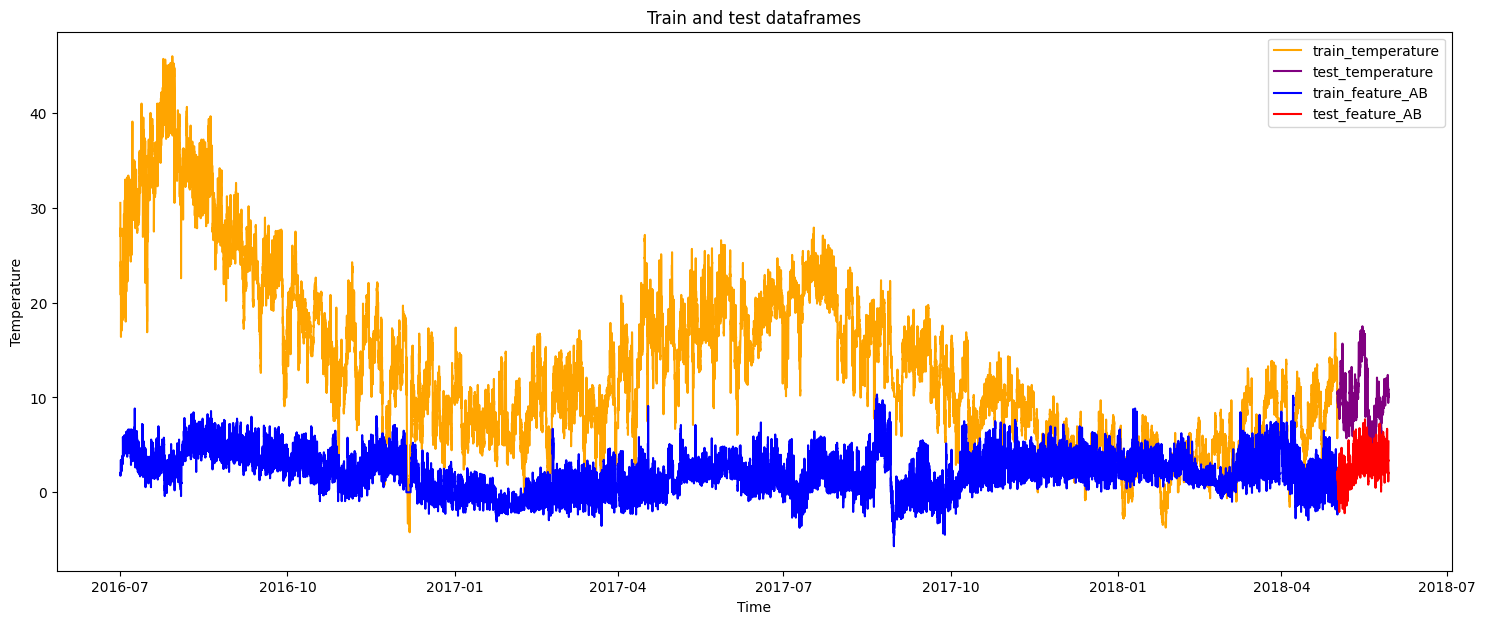

In [164]:
plt.figure(figsize=(18,7))
plt.plot(train_df['date'], train_df['Temperature'], label='train_temperature', color='orange')
plt.plot(test_df['date'], test_df['Temperature'], label='test_temperature', color='purple')
plt.plot(train_df['date'], train_df['feature_AB'], label='train_feature_AB', color='blue')
plt.plot(test_df['date'], test_df['feature_AB'], label='test_feature_AB', color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Train and test dataframes")
plt.legend()
plt.show()

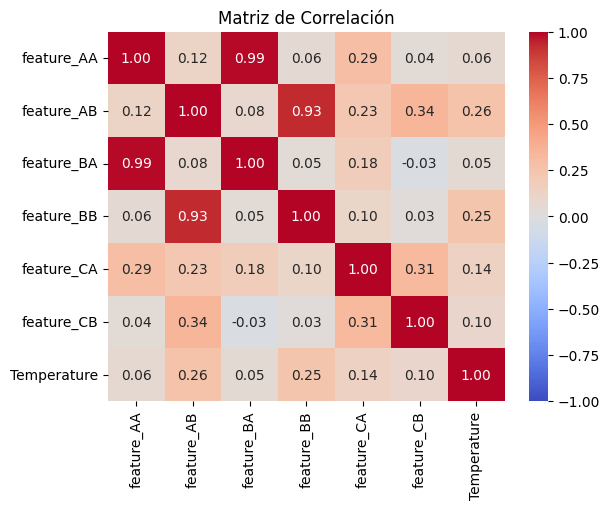

In [38]:
numerical_columns = train_df.select_dtypes(include=['float32']).columns
corr_matrix = train_df[numerical_columns].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

## **Models**

In [55]:
def plot_intervals(x: pd.Series, mean: np.ndarray, lower: np.ndarray, upper: np.ndarray, real: np.ndarray) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(x, mean, label='Mean Prediction', color='blue')
    plt.fill_between(x, lower, upper, color='red', alpha=0.1, label='Confidence Interval')
    plt.plot(x, real, label="Real", color='black')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Prediction with Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### **1. LGBMRegressor**

#### **Preprocessing**

In [7]:
quantiles = [0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]
quantile_mapping = {
    0.95: ('0.025', '0.975'),
    0.9: ('0.05', '0.95'),
    0.8: ('0.10', '0.90'),
    0.7: ('0.15', '0.85'),
    0.6: ('0.20', '0.80'),
    0.5: ('0.25', '0.75'),
    0.4: ('0.30', '0.70'),
    0.3: ('0.35', '0.65'),
    0.2: ('0.40', '0.60'),
    0.1: ('0.45', '0.55')
}

X_train, y_train = train_df.drop(columns=['date', 'Temperature']), train_df['Temperature']
public_test_df = train_and_public_df[64320:].copy()
# predigo las 5k de test y ploteo la comparación con las 2,5k públicas mas las 2,5k que no se saben
test_5k_df = pd.read_csv('data/temperature-forecasting-challenge/test.csv', index_col=['id'])
test_5k_df['date'] = pd.to_datetime(test_5k_df['date'])
X_test = test_5k_df.drop(columns=['date'])

#### **Model training**

In [14]:
coverage_models = {}
for cov_percentage, (q_low, q_high) in quantile_mapping.items():
    model_lgbm_low = LGBMRegressor(objective='quantile', alpha=float(q_low), verbose=-1)
    model_lgbm_low.fit(X_train, y_train)
    model_lgbm_high = LGBMRegressor(objective='quantile', alpha=float(q_high), verbose=-1)
    model_lgbm_high.fit(X_train, y_train)
    coverage_models[cov_percentage] = (model_lgbm_low, model_lgbm_high)

median_model = LGBMRegressor(objective='quantile', alpha=0.5, verbose=-1)
median_model.fit(X_train, y_train)
predictions_median = median_model.predict(X_test)

predictions_df = pd.DataFrame({"id": test_5k_df.index})
for cov_percentage, (model_lgbm_low, model_lgbm_high) in coverage_models.items():
    low_str, high_str = quantile_mapping[cov_percentage]
    predictions_df[low_str]  = model_lgbm_low.predict(X_test)
    predictions_df[high_str] = model_lgbm_high.predict(X_test)

predictions_df['0.50'] = predictions_median

# reorder df and create submission file
float_cols = predictions_df.select_dtypes(include=['float']).columns.tolist()
ordered_cols = sorted(float_cols)
new_order = ['id'] + ordered_cols
predictions_df = predictions_df[new_order]
predictions_df.to_csv('results/1_LGBMRegressor_submission.csv', index=False)

#### **Plotting results**

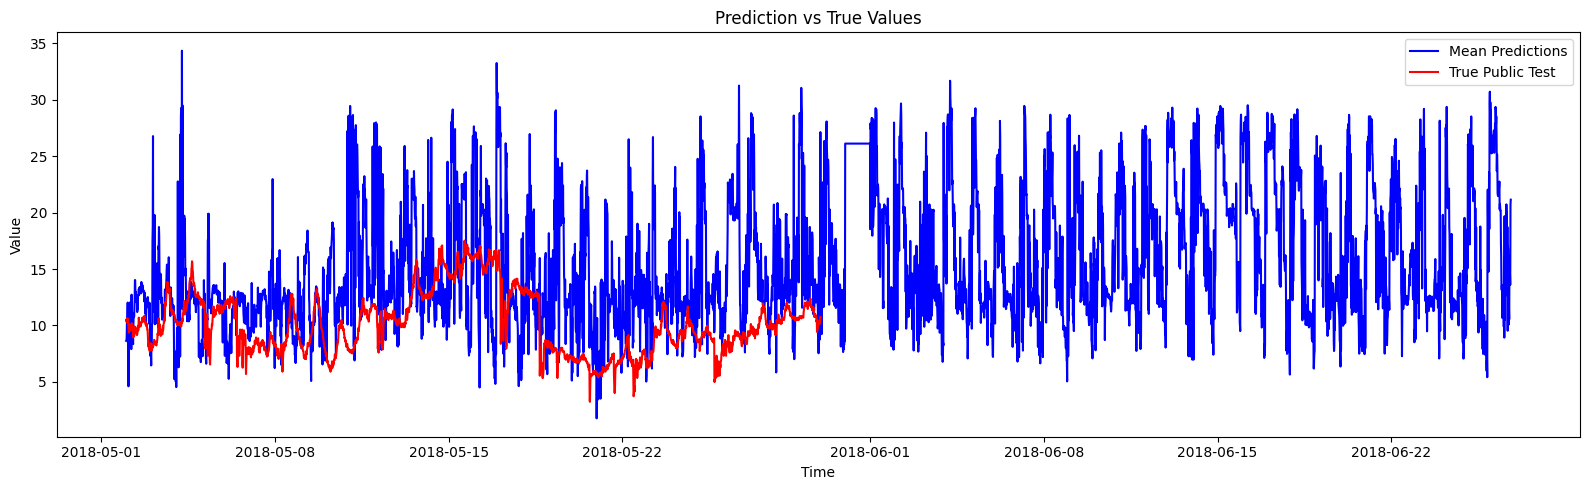

In [ ]:
# x-> timestamp
# mean-> media (valor del medio)
# lower-> intevalo de confianza menor
# upper-> intervalo de confianza superior

plt.figure(figsize=(16, 5))
plt.plot(test_5k_df['date'], predictions_df['0.50'], label='Mean Predictions', color='blue')
plt.plot(test_5k_df['date'][:len(public_test_df)], public_test_df['Temperature'], label='True Public Test', color='red')
# plt.fill_between(predictions_df['0.50'], predictions_df['0.25'], predictions_df['0.75'], color='blue', alpha=0.2, label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs True Values')
plt.legend()
plt.tight_layout()
plt.show()

#### **Kaggle submission**

In [ ]:
from SERTEMP_challenge_CRPS_score import crps, coverage_report

prueba_predictions_df = predictions_df[:len(test_df)].drop(columns=['id'])
crps_score = crps(prueba_predictions_df, test_df) # 2,5k predictions
print(f"Public CRPS score LGBMRegressor: {crps_score:.3f}")
print("*"*50)
# TODO: fix coverage report
# coverage_report(submission=prueba_predictions_df, solution=test_5k_df)

Public CRPS score LGBMRegressor: 3.412
**************************************************


![LGBMRegressor Submission](results/1_LGBMRegressor_submission.png)

### **2. Prophet**

#### **Preprocessing**

In [14]:
real_test_df = pd.read_csv('data/temperature-forecasting-challenge/test.csv')

train_modified = train_df.copy().reset_index().rename(columns={'date':'ds', 'Temperature':'y'})
train_modified.drop(["id", "feature_BA", "feature_BB"], inplace=True, axis=1)
train_modified['ds'] = pd.to_datetime(train_modified['ds'])
train_modified = train_modified.dropna()  # or use fillna()

test_modified = test_df.copy().reset_index().rename(columns={'date':'ds', 'Temperature':'y'})
test_modified.drop(["id","feature_BA","feature_BB",],inplace=True,axis=1)
test_modified['ds'] = pd.to_datetime(test_modified['ds'])
test_modified = test_modified.dropna() 

regressors = ["feature_AA", "feature_AB", "feature_CA", "feature_CB"]

scaler=StandardScaler()
scaler.fit(train_modified[regressors])
scaled_features = scaler.transform(train_modified[regressors])
train_modified[regressors] = scaled_features
scaled_features = scaler.transform(test_modified[regressors])
test_modified[regressors] = scaled_features

y = test_modified['y']
test_modified.drop(["y"], inplace=True, axis=1)

submission = pd.DataFrame(columns=['id','0.025','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45',
                                   '0.5','0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','0.975'])

submission['id'] = real_test_df['id'].values

real_test = real_test_df.copy().reset_index().rename(columns={'date':'ds'})
real_test.drop(["index", "feature_BA", "feature_BB", 'id'], inplace=True, axis=1)
real_test['ds'] = pd.to_datetime(real_test['ds'])
real_test = real_test.dropna() 
scaled_features = scaler.transform(real_test[regressors])
real_test[regressors] = scaled_features

#### **Training**

In [ ]:
confidence_intervals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.95]
dicts = {
    0.1: ['0.45','0.55'],
    0.2: ['0.4','0.6'],
    0.3: ['0.35','0.65'],
    0.4: ['0.3','0.7'],
    0.5: ['0.25','0.75'],
    0.6: ['0.2','0.8'],
    0.7: ['0.15','0.85'],
    0.8: ['0.1','0.9'],
    0.9: ['0.05','0.95'],
    0.95: ['0.025','0.975']
}

for alpha in tqdm(confidence_intervals, desc="Training models", unit="model"):
    model_prophet = Prophet(interval_width=alpha)
    for reg in regressors:
        model_prophet.add_regressor(reg)

    print(f"Training model with confidence interval {alpha}")
    model_prophet.fit(train_modified)

    forecast = model_prophet.predict(real_test)
    forecast_val = model_prophet.predict(test_modified)
    print(f"RMSE with confidence interval {alpha}: {np.sqrt(mean_squared_error(y, forecast_val['yhat'].values)):.3f}")
    if alpha == 0.5:
        submission['0.5'] = forecast['yhat'].values
    else:
        submission[dicts[alpha][0]] = forecast['yhat_lower'].values
        submission[dicts[alpha][1]] = forecast['yhat_upper'].values
df = submission[['id'] + sorted([col for col in submission.columns if col != 'id'], key=lambda x: float(str(x).replace(',', '.')))]
df.to_csv('results/2_Prophet_submission.csv',index=False)

Training models:   0%|          | 0/10 [00:00<?, ?model/s]

Training model with confidence interval 0.1


11:23:08 - cmdstanpy - INFO - Chain [1] start processing
11:25:40 - cmdstanpy - INFO - Chain [1] done processing
Training models:  10%|█         | 1/10 [02:36<23:28, 156.45s/model]

RMSE with confidence interval 0.1: 2.695
Training model with confidence interval 0.2


11:25:44 - cmdstanpy - INFO - Chain [1] start processing
11:28:08 - cmdstanpy - INFO - Chain [1] done processing
Training models:  20%|██        | 2/10 [05:04<20:12, 151.55s/model]

RMSE with confidence interval 0.2: 2.695
Training model with confidence interval 0.3


11:28:12 - cmdstanpy - INFO - Chain [1] start processing
11:30:48 - cmdstanpy - INFO - Chain [1] done processing
Training models:  30%|███       | 3/10 [07:44<18:07, 155.37s/model]

RMSE with confidence interval 0.3: 2.695
Training model with confidence interval 0.4


11:30:52 - cmdstanpy - INFO - Chain [1] start processing
11:33:18 - cmdstanpy - INFO - Chain [1] done processing
Training models:  40%|████      | 4/10 [10:14<15:18, 153.08s/model]

RMSE with confidence interval 0.4: 2.695
Training model with confidence interval 0.5


11:33:22 - cmdstanpy - INFO - Chain [1] start processing
11:36:04 - cmdstanpy - INFO - Chain [1] done processing
Training models:  50%|█████     | 5/10 [13:00<13:08, 157.74s/model]

RMSE with confidence interval 0.5: 2.695
Training model with confidence interval 0.6


11:36:08 - cmdstanpy - INFO - Chain [1] start processing
11:41:44 - cmdstanpy - INFO - Chain [1] done processing
Training models:  60%|██████    | 6/10 [18:41<14:41, 220.29s/model]

RMSE with confidence interval 0.6: 2.695
Training model with confidence interval 0.7


11:41:50 - cmdstanpy - INFO - Chain [1] start processing
11:49:33 - cmdstanpy - INFO - Chain [1] done processing
Training models:  70%|███████   | 7/10 [26:32<15:06, 302.08s/model]

RMSE with confidence interval 0.7: 2.695
Training model with confidence interval 0.8


11:49:42 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing
Training models:  80%|████████  | 8/10 [31:35<10:04, 302.41s/model]

RMSE with confidence interval 0.8: 2.695
Training model with confidence interval 0.9


11:54:44 - cmdstanpy - INFO - Chain [1] start processing
11:56:56 - cmdstanpy - INFO - Chain [1] done processing
Training models:  90%|█████████ | 9/10 [33:52<04:10, 250.89s/model]

RMSE with confidence interval 0.9: 2.695
Training model with confidence interval 0.95


11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:59:13 - cmdstanpy - INFO - Chain [1] done processing
Training models: 100%|██████████| 10/10 [36:10<00:00, 217.05s/model]

RMSE with confidence interval 0.95: 2.695


#### **Results**

2.6954733860393985


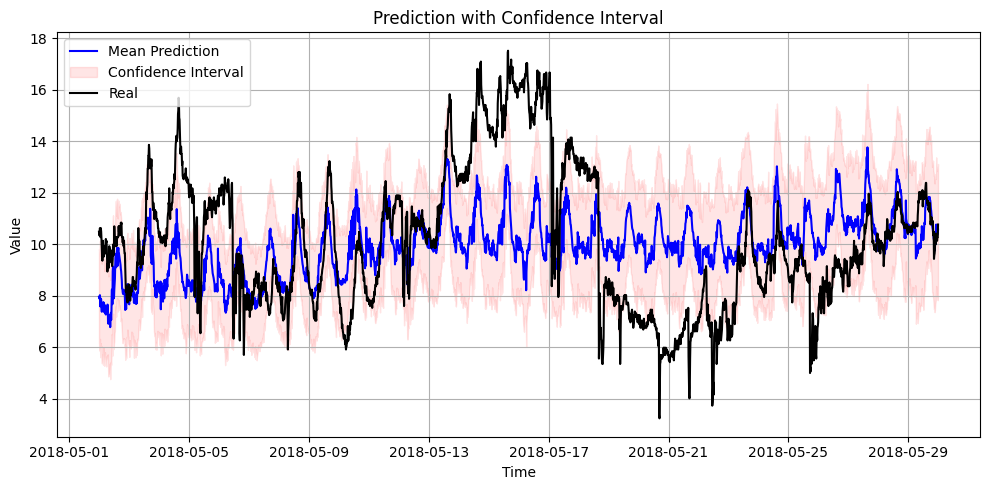

In [ ]:
rmse_prophet = np.sqrt(mean_squared_error(y, forecast['yhat'].values))

print(rmse_prophet)
plot_intervals(forecast['ds'].values, forecast['yhat'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, y)

#### **Kaggle Submission**

![Prophet Submission](results/2_Prophet_submission.jpeg)

### **3. Random Forest**

#### **Preprocessing**

In [ ]:
columns = ['id','0.025','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45',
           '0.5','0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','0.975']

submission = pd.DataFrame(columns=columns)
submission['id'] = real_test_df['id'].values

X_train = train_modified.drop(columns=['y', 'ds'], axis=1).values
y_train = train_modified['y'].values
X_test = test_modified.drop(columns=['ds'], axis=1).values
y_test = y.values
X_real_test = real_test.drop(columns=['ds'], axis=1).values

#### **Model training**

In [33]:
forest = RandomForestQuantileRegressor(n_estimators=100, q=[0.025,0.05,0.1,0.15, 0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                                                            0.55, 0.6, 0.65, 0.7,0.75, 0.8,0.85, 0.9, 0.95, 0.975], n_jobs=-1)

start = time.time()
forest.fit(X_train, y_train)
minutos, segundos = divmod(time.time() - start, 60)
print(f"***** Tiempo de entrenamiento: {int(minutos)} minutos {segundos:.2f} segundos *****")

***** Tiempo de entrenamiento: 0 minutos 2.11 segundos *****


#### **Results**

RMSE RandomForest: 10.581


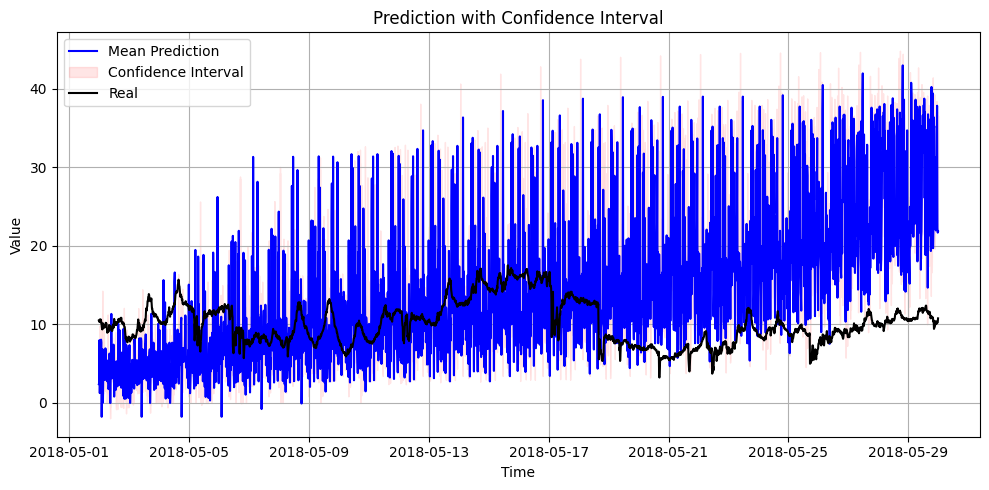

In [31]:
test_predictions = forest.predict(X_test)
test_predictions = test_predictions.reshape(-1, 21)
median = test_predictions[:,10]
rmse_forest = np.sqrt(mean_squared_error(y_test, median))
print(f"RMSE RandomForest: {rmse_forest:.3f}")

real_test_predictions = forest.predict(X_real_test)
real_test_predictions = real_test_predictions.reshape(-1, 21)

for i in range(1,22):
    submission[columns[i]] = real_test_predictions[:,i-1]
df = submission[['id'] + sorted([col for col in submission.columns if col != 'id'], key=lambda x: float(str(x).replace(',', '.')))]
df.to_csv('results/3_RandomForest_submission.csv', index=False)

plot_intervals(test_modified['ds'], median, test_predictions[:,7], test_predictions[:,13], y_test)

#### **Kaggle Submission**

![RandomForest Submission](results/3_RandomForest_submission.jpeg)

### **4. Pytorch Forecasting: MQF2DistributionLoss**

In [ ]:
from pytorch_forecasting.metrics.distributions import MQF2DistributionLoss